In [1]:
import torch
import torch.nn as nn
import numpy as np
from transformers import BertModel, AutoTokenizer, BertConfig
import matplotlib.pyplot as plt
import pickle 
from process_data_new import process_data

In [2]:
torch.set_default_dtype(torch.float64)

In [ ]:
V_data, CDR3_data, J_data, tgt_data = process_data()

If you have the data saved as an pkl object use following cell

In [3]:
with open('train_set_.pkl', 'rb') as f:
    V_data, CDR3_data, J_data, tgt_data = pickle.load(f)
f.close()

In [4]:
base_model = BertModel.from_pretrained('Rostlab/prot_bert_bfd')
tokenizer = AutoTokenizer.from_pretrained('Rostlab/prot_bert_bfd', add_special_tokens=False)
config = BertConfig.from_pretrained('Rostlab/prot_bert_bfd')

In [5]:
print(config)

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 40000,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 30,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.31.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30
}



In [6]:
print(base_model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30, 1024, padding_idx=0)
    (position_embeddings): Embedding(40000, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-29): 30 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.0, inpla

In [7]:
for i in base_model.encoder.layer[0].attention.self.parameters():
    print(i.shape)
    break

torch.Size([1024, 1024])


# Copy weights to own model

https://stackoverflow.com/questions/70814490/uploading-models-with-custom-forward-functions-to-the-huggingface-model-hub

https://stackoverflow.com/questions/67689219/copy-one-layers-weights-from-one-huggingface-bert-model-to-another

https://github.com/huggingface/transformers/blob/main/src/transformers/models/bert/modeling_bert.py

https://discuss.pytorch.org/t/copy-weights-from-only-one-layer-of-one-model-to-another-model-with-different-structure/153419

In [8]:
import transformers 
import torch.nn as nn

class CustomprotBERT(transformers.PreTrainedModel):
    def __init__(self, protBERT, CDR3_max_length):
        super(CustomprotBERT, self).__init__(config=BertConfig.from_pretrained('Rostlab/prot_bert_bfd'))
        
        self.config = protBERT.config
        self.CDR3_max_length = CDR3_max_length
        self.embeddings = protBERT.embeddings
        self.encoder= nn.TransformerEncoder(encoder_layer= nn.TransformerEncoderLayer(  d_model=self.config.hidden_size,
                                                                                        nhead=self.config.num_attention_heads,
                                                                                        dim_feedforward=self.config.intermediate_size,
                                                                                        dropout=self.config.hidden_dropout_prob,
                                                                                        activation=self.config.hidden_act,
                                                                                        layer_norm_eps=self.config.layer_norm_eps,
                                                                                        batch_first=True),
                                          num_layers = self.config.num_hidden_layers)
        self.fc = nn.Linear(config.hidden_size, self.config.vocab_size)

        self.initialize_weights(protBERT)

    def forward(self, src, length, pad_mask=None,  mask=None):
        
        embed = self.embeddings(src)
        mask = mask.repeat((self.config.num_attention_heads,1,1)) if mask != None else mask
        hidden_state = self.encoder(src=embed,
                                    mask=mask,
                                    src_key_padding_mask =pad_mask)
        
        #v_idx = [i.shape[-1] -1 for i in v] # Indeces of the last value of the v gene
        #cdr3_idx = [i + self.CDR3_max_length for i in v_idx] # Indeces of the last residue of the CDR3
        
        cdr3_hidden_state = torch.zeros((hidden_state.shape[0], self.CDR3_max_length, hidden_state.shape[-1]))
        
        for i in range(hidden_state.shape[0]):
            cdr3_len = length[i,1]
            pad_len = self.CDR3_max_length -cdr3_len
            cdr3 = hidden_state[i, length[i,0]-1:length[i,0]-1+ length[i,1],:]
            pad_seq = torch.full((pad_len, hidden_state.shape[-1]), 0).to(device)
            cdr3 = torch.cat((cdr3, pad_seq), axis=0)
            cdr3_hidden_state[i,:,:] = cdr3 #1024 dim presentation of [V_v, CDR_1, ..., CDR_{N-1}]
        
        cdr3_logits = self.fc(cdr3_hidden_state)
        
        return cdr3_logits   

    
    def initialize_weights(self, protBERT):

            #this implementation works so that theresulting tensor is same as using 
            #Huggingface's model on the fourth decimal. Tensors are same in fifth decimal over 99.99%

            protBERT_encoder_weights = protBERT.encoder.state_dict()
            with torch.no_grad():
                for i in range(30):
                    weights = {
                        'att_weight': torch.cat((protBERT_encoder_weights[f'layer.{i}.attention.self.query.weight'],
                                                    protBERT_encoder_weights[f'layer.{i}.attention.self.key.weight'],
                                                    protBERT_encoder_weights[f'layer.{i}.attention.self.value.weight']),
                                                    axis=0),
                        'att_bias': torch.cat((protBERT_encoder_weights[f'layer.{i}.attention.self.query.bias'],
                                                    protBERT_encoder_weights[f'layer.{i}.attention.self.key.bias'],
                                                    protBERT_encoder_weights[f'layer.{i}.attention.self.value.bias']),
                                                    axis=0),
                        'att_out_weight': protBERT_encoder_weights[f'layer.{i}.attention.output.dense.weight'],
                        'att_out_bias': protBERT_encoder_weights[f'layer.{i}.attention.output.dense.bias'],
                        'interm_weight': protBERT_encoder_weights[f'layer.{i}.intermediate.dense.weight'],
                        'interm_bias': protBERT_encoder_weights[f'layer.{i}.intermediate.dense.bias'],
                        'out_weight': protBERT_encoder_weights[f'layer.{i}.output.dense.weight'],
                        'out_bias': protBERT_encoder_weights[f'layer.{i}.output.dense.bias'],
                        'norm1_weight': protBERT_encoder_weights[f'layer.{i}.attention.output.LayerNorm.weight'],
                        'norm1_bias': protBERT_encoder_weights[f'layer.{i}.attention.output.LayerNorm.bias'],
                        'norm2_weight': protBERT_encoder_weights[f'layer.{i}.output.LayerNorm.weight'],
                        'norm2_bias': protBERT_encoder_weights[f'layer.{i}.output.LayerNorm.bias'],
                    }

                    #print(weights['out_weight'].dtype)
                    #print(self.encoder.layers[i].self_attn.in_proj_weight.dtype)

                    self.encoder.layers[i].self_attn.in_proj_weight.copy_(weights['att_weight'])
                    self.encoder.layers[i].self_attn.in_proj_bias.copy_(weights['att_bias'])
                    self.encoder.layers[i].self_attn.out_proj.weight.copy_(weights['att_out_weight'])
                    self.encoder.layers[i].self_attn.out_proj.bias.copy_(weights['att_out_bias'])
                    self.encoder.layers[i].linear1.weight.copy_(weights['interm_weight'])
                    self.encoder.layers[i].linear1.bias.copy_(weights['interm_bias'])
                    self.encoder.layers[i].linear2.weight.copy_(weights['out_weight'])
                    self.encoder.layers[i].linear2.bias.copy_(weights['out_bias'])
                    self.encoder.layers[i].norm1.weight.copy_(weights['norm1_weight'])
                    self.encoder.layers[i].norm1.bias.copy_(weights['norm1_bias'])
                    self.encoder.layers[i].norm2.weight.copy_(weights['norm2_weight'])
                    self.encoder.layers[i].norm2.bias.copy_(weights['norm2_bias'])

In [9]:
CustomprotBERT(base_model, 18)

CustomprotBERT(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30, 1024, padding_idx=0)
    (position_embeddings): Embedding(40000, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-29): 30 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (linear1): Linear(in_features=1024, out_features=4096, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=4096, out_features=1024, bias=True)
        (norm1): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
        (norm2): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2): Dropout(

In [5]:
import torch

class CDR3Dataset(torch.utils.data.Dataset):
    def __init__(self, V, CDR3, J, tgt, tokenizer):

        self.tokenizer = tokenizer
        self.V = V
        self.CDR3 = CDR3
        self.J = J
        self.labels = tgt
        
        if len(tgt) == 1:
            self.max_length = len(tgt[0].split()) + 3
            self.CDR3_max_length = len(CDR3[0].split())
            # self.V_max_length = len(V[0].split())
            # self.J_max_length = len(J[0].split())
        else:
            length = 0
            V_length = 0
            CDR3_length = 0
            J_length = 0
            for i in range(len(tgt)):
                length = max(length, len(tgt[i].split())+3)
                CDR3_length = max(CDR3_length, len(CDR3[i].split()))
                # V_length = max(V_length, len(V[i].split()))
                # J_length = max(J_length, len(J[i].split()))

            self.max_length = length
            self.CDR3_max_length = CDR3_length
           # self.V_max_length = V_length +1 #[CLS]
           # self.J_max_length =  J_length + 2 #[SEP] and one [PAD]
           # print(self.CDR3_max_length)
 
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        tokenized = self.tokenizer(self.labels[idx], padding= 'max_length', max_length= self.max_length, return_tensors='pt', return_attention_mask=True)
        padded_tokenized_seq = tokenized['input_ids']
        pad_mask = ~tokenized['attention_mask'].to(torch.bool)
        
        
        v_len = len(self.V[idx].replace(" ", "")) + 1 # Tokenizer adds [CLS] token at the beginning of the sequence
        cdr_len = len(self.CDR3[idx].replace(" ", ""))
        j_len = padded_tokenized_seq.shape[-1]- v_len- cdr_len
        lengths = torch.tensor([v_len, cdr_len])
        
        mask = self.subsequent_mask(v_len, cdr_len, j_len)
        
        CDR3_label = torch.cat((padded_tokenized_seq[:, v_len: v_len+cdr_len], torch.full((1, self.CDR3_max_length - len(self.CDR3[idx].split())), -100)), dim=-1)
        
        item = {'seq': padded_tokenized_seq.squeeze(0),
                'length': lengths,
                'mask': mask,
                'pad_mask': pad_mask.squeeze(0),
                'CDR3_label': CDR3_label.squeeze(0)}
        
        return item
    
    def subsequent_mask(self, v, cdr3, j):

        cdr3_len = cdr3
        v_len = v
        j_len = j

        v_block1 = np.zeros(shape=(v_len, v_len))
        v_block2 = np.zeros(shape=(cdr3_len, v_len))
        v_block3 = np.zeros(shape=(j_len, v_len))

        j_block1 = np.zeros(shape=(v_len, j_len))
        j_block2 = np.zeros(shape=(cdr3_len, j_len))
        j_block3 = np.zeros(shape=(j_len, j_len))

        cdr3_block1 = np.full(shape=(v_len, cdr3_len), fill_value=np.NINF)
        cdr3_block2 = np.triu(np.full((cdr3_len, cdr3_len), np.NINF), k = 0)
        cdr3_block3 = np.full(shape=(j_len, cdr3_len), fill_value=np.NINF)

        row1 = np.concatenate((v_block1, cdr3_block1, j_block1), axis=1)
        row2 = np.concatenate((v_block2, cdr3_block2, j_block2), axis=1)
        row3 = np.concatenate((v_block3, cdr3_block3, j_block3), axis=1)

        attention_mask = np.concatenate((row1, row2, row3), axis =0)

        return torch.from_numpy(attention_mask) != 0

In [6]:
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
train_set = CDR3Dataset(V_data[0:100], CDR3_data[0:100], J_data[0:100], tgt_data[0:100], tokenizer)
train_loader = DataLoader(train_set, shuffle=False, batch_size=8)

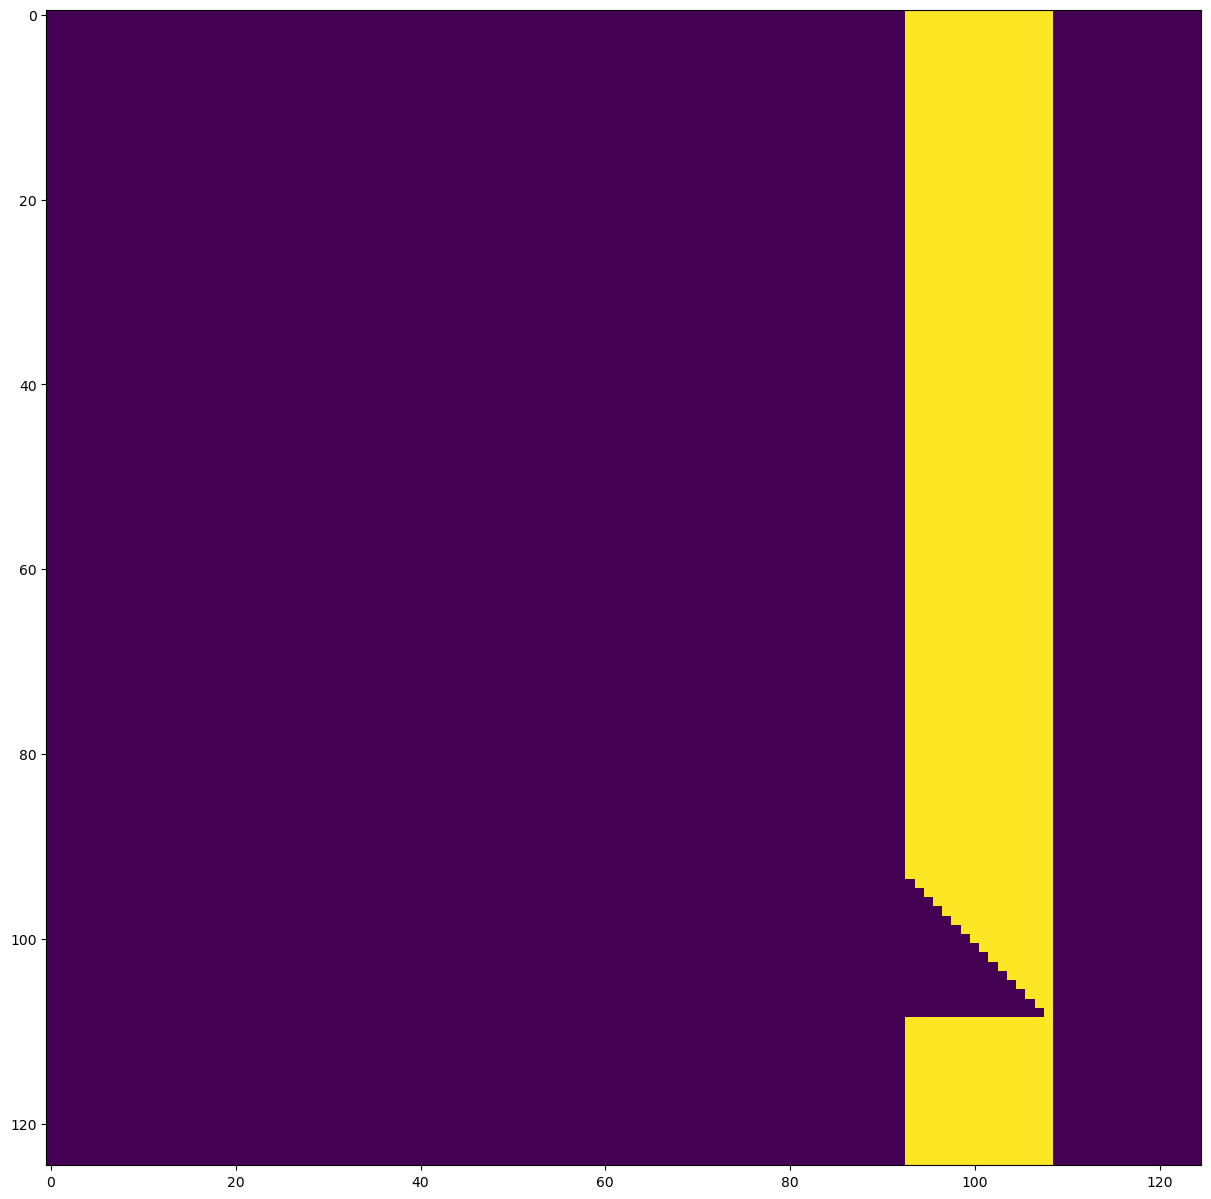

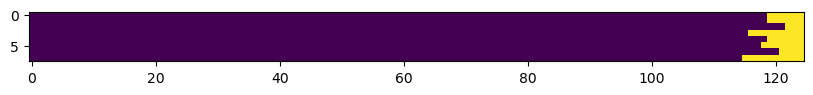

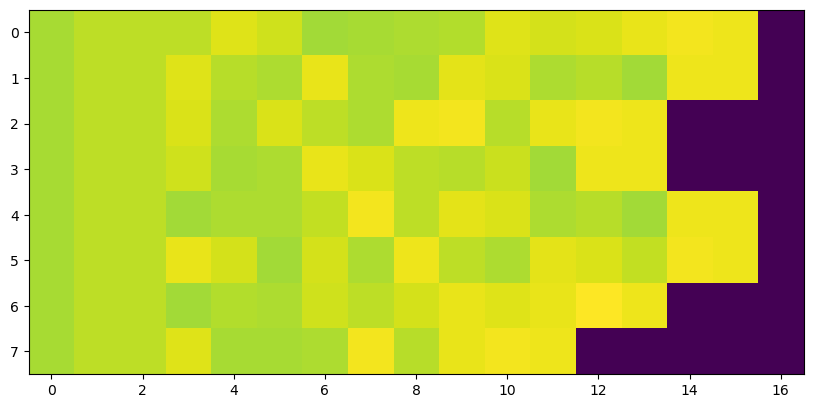

In [8]:
for batch in train_loader:
    for k, v in batch.items():
        if k =='mask':
            plt.figure(figsize=(15,15))
            plt.imshow(v[0])
            plt.savefig("mask.png")
        if k== 'pad_mask':
            plt.figure(figsize=(10,10))
            plt.imshow(v)
            
        if k=='CDR3_label':
            plt.figure(figsize=(10,10))
            plt.imshow(v)
    break

# Train loop

In [37]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = CustomprotBERT(base_model, train_set.CDR3_max_length).to(device)
EPOCHS = 10
optimizer = torch.optim.AdamW(model.parameters(), lr= 1e-6)
criterion = torch.nn.CrossEntropyLoss().to(device)

In [41]:
model.train()

for epoch in range(EPOCHS):
    loop = tqdm(train_loader, leave=True, position=0, desc=f'epoch:{epoch+1}/{EPOCHS}')
    for idx, batch in enumerate(loop):
        batch = {k: v.to(device) for k, v in batch.items()}
        
        '''
        length = batch['length']
        print(tokenizer.decode(batch['seq'][1, length[1,0]-1:length[1,0]-1+ length[1,1]]))
        break
        '''
        logits = model(src = batch['seq'],
                       length = batch['length'],
                       pad_mask = batch['pad_mask'],
                       mask = batch['mask'])

        
        loss = criterion(logits.transpose(1,2), batch['CDR3_label'])
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        perplexity = torch.exp(loss)
        loop.set_postfix(loss = loss.item(), PPL=perplexity.item())

epoch:1/10:   0%|          | 0/64273 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
residues = torch.argmax(torch.softmax(logits, dim=-1), dim=-1)
print(tokenizer.decode(residues[0,:]))

label = batch['CDR3_label'][0,:]
label[label==-100] = 0

print(tokenizer.decode(label.squeeze(0)))

# Testing

In [14]:
checkpoint = torch.load("../code/model_2/030823_customprotBERT_parallel_checkpoint.pth",  map_location="cpu")

In [15]:
model = checkpoint["model"]
model = model.module

In [16]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
model.eval()

CustomprotBERT(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30, 1024, padding_idx=0)
    (position_embeddings): Embedding(40000, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-29): 30 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (linear1): Linear(in_features=1024, out_features=4096, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=4096, out_features=1024, bias=True)
        (norm1): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
        (norm2): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2): Dropout(

In [17]:
train_set = CDR3Dataset(V_data[20000000:200000101], CDR3_data[20000000:200000101], J_data[20000000:200000101], tgt_data[20000000:200000101], tokenizer)
train_loader = DataLoader(train_set, shuffle=False, batch_size=100)

In [30]:
with torch.no_grad():
    for batch in train_loader:
        idx = 89
        prob = []
        
        cdr3_pred =torch.full((1,int(batch['length'][idx,1])), 0).squeeze(0)
        V = batch['seq'][idx,:batch['length'][idx,0]]
        J = batch['seq'][idx,batch['length'][idx,0]+batch['length'][idx,1]:]
        #print(tokenizer.decode(V))
        for i in tqdm(range(int(batch['length'][idx,1])), leave=True, position=0):
            
            src = torch.cat((V,cdr3_pred,J), axis=-1).unsqueeze(0)
            out = model(src=src,
                       length = batch['length'][idx, :].unsqueeze(0))
            
            #cdr3_pred[i]= torch.multinomial(out.softmax(-1)[:,i], num_samples=1)
            cdr3_pred[i]= out.softmax(-1).argmax(-1)[:,i]
            prob.append(out.softmax(-1)[:,i,:])
        break

100%|██████████| 14/14 [00:25<00:00,  1.80s/it]


In [31]:
print(tokenizer.decode(cdr3_pred))
for batch in train_loader:
    label = batch['CDR3_label'][idx]
    label[label==-100] = 0
    print(tokenizer.decode(label.squeeze(0)))
    break

S S F L L L L H Q Y L H F F
A S S Q T I S P G N T I Y F [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [32]:
names = [tokenizer.decode(i) for i in range(0,30)]

<function matplotlib.pyplot.show(close=None, block=None)>

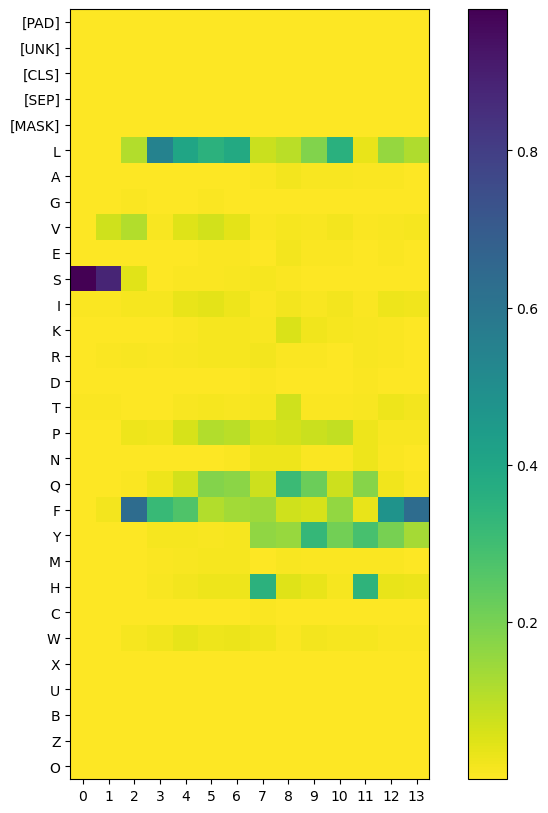

In [33]:
plt.figure(figsize=(10,10))
plt.imshow(torch.cat(prob, dim=0).t(), cmap='viridis_r')
plt.yticks(range(0,30), names)
plt.xticks(range(0,int(batch['length'][idx, 1])), range(0, int(batch['length'][idx, 1])))
plt.colorbar()
plt.show

In [ ]:
plt.figure(figsize=(200,200))
plt.imshow(model.fc.weight.detach().softmax(-1), cmap='viridis_r')

In [ ]:
print(torch.argmax(torch.cat(prob), dim =-1))

In [ ]:
torch.cat(prob)[0]

In [ ]:
tokenizer.decode(batch['V'][0])